In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import strategy.trendlabeling as tlb
import numpy as np
import datetime

import getdata as gd
import afml.filters as flt 
import afml.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

1. Import Dataset

In [2]:
df_yf = gd.get_yf_data(tickers= "SPY AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  5 of 5 completed


In [3]:
df = df_yf[df_yf['Ticker'] == 'ALGM']

In [4]:
fig = go.Figure(data=go.Candlestick(x=df.index,
                    open=df.Open,
                    high=df.High,
                    low=df.Low,
                    close=df['Adj Close']))
fig.show()

2. Form Dollar Bars

In [5]:
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

In [6]:
# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
ans = bars.generate_dollarbars(trades, frequency=frequency) 

In [7]:
fig = go.Figure(data=go.Candlestick(x=ans.index,
                    open=ans['open'],
                    high=ans['high'],
                    low=ans['low'],
                    close=ans['close']))
fig.show()

3. Run cusum filter to get std dev of daily returns at equal threshold

In [8]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(ans.close, span=50)

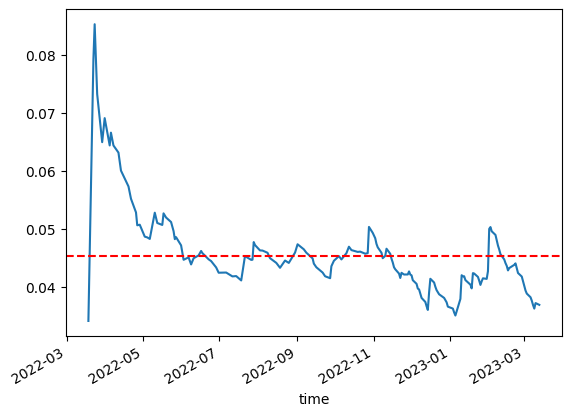

In [9]:
# show volitility over time

f,ax=plt.subplots()
dailyVolatility.plot(ax=ax)
ax.axhline(dailyVolatility.mean(),ls='--',color='r')

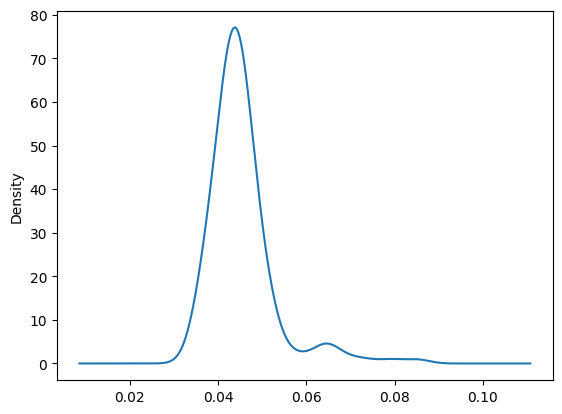

In [10]:
#show distribution of volitility
ax = dailyVolatility.plot.kde()

In [11]:
# apply cusum filter
tEvents = flt.getTEvents(ans.close,h=dailyVolatility.mean())
tEvents

DatetimeIndex(['2022-03-17 08:00:00', '2022-03-18 08:00:00',
               '2022-03-22 08:00:00', '2022-03-23 08:00:00',
               '2022-03-25 08:00:00', '2022-03-29 08:00:00',
               '2022-03-31 08:00:00', '2022-04-04 08:00:00',
               '2022-04-05 08:00:00', '2022-04-07 08:00:00',
               ...
               '2023-02-28 08:00:00', '2023-03-01 08:00:00',
               '2023-03-02 08:00:00', '2023-03-03 08:00:00',
               '2023-03-06 08:00:00', '2023-03-07 08:00:00',
               '2023-03-08 08:00:00', '2023-03-09 08:00:00',
               '2023-03-10 08:00:00', '2023-03-13 08:00:00'],
              dtype='datetime64[ns]', length=156, freq=None)

4. Add vertical barrier a.k.a. event end date

In [12]:
# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, ans.close, num_days=num_days)
t1

2022-03-17 08:00:00   2022-03-29 08:00:00
2022-03-18 08:00:00   2022-03-29 08:00:00
2022-03-22 08:00:00   2022-04-04 08:00:00
2022-03-23 08:00:00   2022-04-04 08:00:00
2022-03-25 08:00:00   2022-04-04 08:00:00
                              ...        
2023-02-27 08:00:00   2023-03-09 08:00:00
2023-02-28 08:00:00   2023-03-10 08:00:00
2023-03-01 08:00:00   2023-03-13 08:00:00
2023-03-02 08:00:00   2023-03-13 08:00:00
2023-03-03 08:00:00   2023-03-13 08:00:00
Name: time, Length: 150, dtype: datetime64[ns]

5. Apply Triple Barrier method where ptSl = [2,1]  (2 to 1 profit ratio). Getting the Time of the First Touch, with Meta Labels

In [13]:
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(ans.close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=None)

print(events)

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\triplebarrier.py:50: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                     t1      trgt  pt  sl
2022-03-18 08:00:00 2022-03-29 08:00:00  0.034114   2   1
2022-03-22 08:00:00 2022-04-04 08:00:00  0.079188   2   1
2022-03-23 08:00:00 2022-04-04 08:00:00  0.085221   2   1
2022-03-25 08:00:00 2022-04-04 08:00:00  0.073197   2   1
2022-03-29 08:00:00 2022-04-07 08:00:00  0.064906   2   1
...                                 ...       ...  ..  ..
2023-03-07 08:00:00                 NaT  0.037601   2   1
2023-03-08 08:00:00                 NaT  0.036856   2   1
2023-03-09 08:00:00                 NaT  0.036239   2   1
2023-03-10 08:00:00                 NaT  0.037192   2   1
2023-03-13 08:00:00                 NaT  0.036886   2   1

[155 rows x 4 columns]


6. Labeling for Side & Size with Meta Labels by generating outcome label using getBins

In [21]:
labels = tbar.get_bins(triple_barrier_events = events, close=ans.close)

In [22]:
print(labels)
print(labels.bin.value_counts())

                          ret      trgt  bin
2022-03-18 08:00:00  0.018644  0.034114    0
2022-03-22 08:00:00 -0.031992  0.079188    0
2022-03-23 08:00:00 -0.006005  0.085221    0
2022-03-25 08:00:00 -0.035641  0.073197    0
2022-03-29 08:00:00 -0.154409  0.064906   -1
...                       ...       ...  ...
2023-02-27 08:00:00  0.053343  0.041761    0
2023-02-28 08:00:00  0.008700  0.040940    0
2023-03-01 08:00:00 -0.010966  0.040141    0
2023-03-02 08:00:00 -0.020145  0.039349    0
2023-03-03 08:00:00 -0.046476  0.038829   -1

[149 rows x 3 columns]
 0    88
-1    31
 1    30
Name: bin, dtype: int64


7. Drop underpopulated labels (snippet 3.8) by eliminating rare observations

In [23]:
clean_labels  = tbar.drop_labels(labels)
print(clean_labels)

                          ret      trgt  bin
2022-03-18 08:00:00  0.018644  0.034114    0
2022-03-22 08:00:00 -0.031992  0.079188    0
2022-03-23 08:00:00 -0.006005  0.085221    0
2022-03-25 08:00:00 -0.035641  0.073197    0
2022-03-29 08:00:00 -0.154409  0.064906   -1
...                       ...       ...  ...
2023-02-27 08:00:00  0.053343  0.041761    0
2023-02-28 08:00:00  0.008700  0.040940    0
2023-03-01 08:00:00 -0.010966  0.040141    0
2023-03-02 08:00:00 -0.020145  0.039349    0
2023-03-03 08:00:00 -0.046476  0.038829   -1

[149 rows x 3 columns]


In [24]:
clean_labels.bin.value_counts()

 0    88
-1    31
 1    30
Name: bin, dtype: int64

8. Apply strategy here to suggest the side, not the bet
    
    8.1 Trendlabeling

    8.2 Mean Reverting BB 

In [25]:
#to do

9. Train model to decide trade or not trade since step 9 already decided a side (up or down)

    9.1 Random Forest

    9.2 SVC

In [18]:
#to do

11. Compare model with or without Secondary Model

In [19]:
# to do